In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import modelingtools

from sklearn import model_selection as ms
from sklearn.preprocessing import scale, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline, Pipeline

In [312]:
## Prep paths ##

subject = 'BJH025'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [313]:
def delay_time_series(X, delays, sfreq):
    """Delay a time series.

    Parameters
    ----------
    X : array, shape (n_epochs, n_features, n_times)
        The data to delay.
    delays : array, shape (n_delays,)
        The delays (in seconds) to create.
    sfreq : float
        The sampling frequency of the data.

    Returns
    -------
    X_delayed : array, shape (n_epochs, n_features, n_delays, n_times)
        The delayed data
    """
    delays_ixs = (delays * sfreq).astype(int)
    X_delayed = np.zeros([X.shape[0], X.shape[1], len(delays), X.shape[-1]])

    for ii, iep in enumerate(X):
        for jj, idelay in enumerate(delays_ixs):
            i_delayed = np.roll(iep, -idelay, axis=-1)
            if idelay <= 0:
                i_slice = slice(-idelay, None)
            else:
                i_slice = slice(None, -idelay)
            X_delayed[ii, :, jj, i_slice] = i_delayed[..., i_slice]
    return X_delayed

In [406]:
## Prep trial data ##

# Load Data #
trial_data = pd.read_csv(f"{preproc_data_dir}/linear_encoding/cleaned_trial_behavior.csv")


# Exclude No Ghost Trials #
ttype_data = trial_data[['Trial', 'TrialType']].drop_duplicates()
noghost_trials = np.where(ttype_data['TrialType'] > 16)[0] # get indices for neural data
trial_data = trial_data[trial_data['TrialType'] <=16]

# Load died events to remove death trials #
death_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_died_events.csv")
death_trials_data = death_data.copy()[death_data['died'] ==1]
death_trials_data['neural_trial_numeric'] = death_trials_data['neural_trial_numeric'] - 1 # because we had to delete the 0 trial to match with the neural data
print(len(ttype_data['Trial']))
death_trials = np.where(ttype_data['Trial'].isin(death_trials_data['neural_trial_numeric']))[0]
trial_data = trial_data[~trial_data['Trial'].isin(death_trials_data['neural_trial_numeric'])]

# # Calculate distance to ghost @#
trial_data['distance_to_ghost'] = np.abs(trial_data['GhostLocation'] - trial_data['UserLocation'])
trial_data['distance_to_ghost'] = scale(trial_data['distance_to_ghost'])

# Create time pre
trial_data['time_pred'] = scale(trial_data['Time'])

# # Extra features and pivot to n_trial x n_time format
var_of_interest_data = trial_data.copy()[['Trial', 'Time', 'distance_to_ghost', 'Eaten', 'time_pred']]
distance_df = var_of_interest_data.copy().pivot(index='Trial', columns='Time', values='distance_to_ghost')
eaten_df = var_of_interest_data.copy().pivot(index='Trial', columns='Time', values='Eaten')
time_df = var_of_interest_data.copy().pivot(index='Trial', columns='Time', values='time_pred')
dist_array = distance_df.to_numpy()
eaten_array = eaten_df.to_numpy()
time_array = time_df.to_numpy()

211


In [407]:
good_neural_trials = [x for x in range(len(ttype_data['Trial'])) if (x not in noghost_trials) and (x not in death_trials)]
len(good_neural_trials)

138

In [408]:
## Prep Neural Data ##

# load neural data #
neural_tfr = mne.time_frequency.read_tfrs(f"{preproc_data_dir}/linear_encoding/theta_I1-I2_ecog-epo.fif")

# Average across freqs and pull out data and exclude noghost and death trials #
neural_tfr = neural_tfr[0]
neural_data = neural_tfr.data.mean(axis = 1).mean(axis = 1)
neural_data = neural_data[good_neural_trials, :]


Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/linear_encoding/theta_I1-I2_ecog-epo.fif ...
Not setting metadata


/tmp/ipykernel_20319/2354696145.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/linear_encoding/theta_I1-I2_ecog-epo.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  neural_tfr = mne.time_frequency.read_tfrs(f"{preproc_data_dir}/linear_encoding/theta_I1-I2_ecog-epo.fif")


In [409]:
## Limit Neural Data to max trial time
for idx, trial in enumerate(trial_data['Trial'].unique()):

    # Calculate the maximum time for the current trial
    max_time = trial_data[trial_data['Trial'] == trial]['Time'].max()

    # Find the corresponding index in the numpy array
    indices = np.where(neural_tfr.times > max_time)[0]

    # Replace values after max_time with np.nan
    neural_data[idx, indices] = np.nan

In [410]:
def delay_time_series(X, delays, sfreq):
    """Delay a time series.

    Parameters
    ----------
    X : array, shape (n_epochs, n_features, n_times)
        The data to delay.
    delays : array, shape (n_delays,)
        The delays (in seconds) to create.
    sfreq : float
        The sampling frequency of the data.

    Returns
    -------
    X_delayed : array, shape (n_epochs, n_features, n_delays, n_times)
        The delayed data
    """
    delays_ixs = (delays * sfreq).astype(int)
    X_delayed = np.empty([X.shape[0], X.shape[1], len(delays), X.shape[-1]])

    for ii, iep in enumerate(X):
        for jj, idelay in enumerate(delays_ixs):
            i_delayed = np.roll(iep, -idelay, axis=-1)
            # print(idelay)
            if idelay < 0:
                i_delayed[..., 0:abs(idelay)] = iep[..., 0:1]
            X_delayed[ii, :, jj, :] = i_delayed
    return X_delayed

In [411]:
# exclude trials with abnormally high power

good_power_list = [trial for trial  in range(neural_data.shape[0]) if np.nanmax(neural_data[trial, :]) < 50]
neural_data = neural_data[good_power_list, :]
dist_array = dist_array[good_power_list, :]
eaten_array = eaten_array[good_power_list, :]
time_array = time_array[good_power_list, :]

In [412]:
# create delayed distance features #

## add singleton to work with the delay_time_series function
dist_array = dist_array[:, np.newaxis, :]
eaten_array = eaten_array[:, np.newaxis, :]
time_array = time_array[:, np.newaxis, :]

# Define our time delays in seconds
delays = np.linspace(-.8, 0., 10)
dist_delayed = delay_time_series(dist_array, delays, 100)
eat_delayed = delay_time_series(eaten_array, delays, 100)
time_delayed = delay_time_series(time_array, delays, 100)

delayed_preds = np.concatenate((dist_delayed, time_delayed), axis=2)

# try with just time
delayed_preds = time_delayed

In [413]:
delayed_preds.shape

(131, 1, 10, 871)

/tmp/ipykernel_20319/365596840.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,


Text(0.5, 1.0, 'Time-Delayed Distance to Ghost')

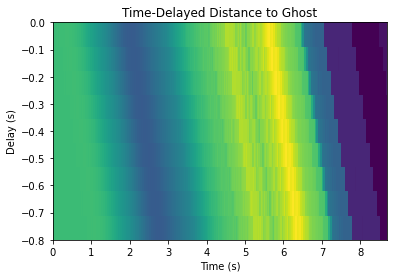

In [414]:
mask_time_ecog = mne.utils._time_mask(neural_tfr.times, 0, 8.7)

fig, ax = plt.subplots()
ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,
              np.nanmean(dist_delayed, axis= 0)[0], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Distance to Ghost')

/tmp/ipykernel_20319/1676151677.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,


Text(0.5, 1.0, 'Time-Delayed Eaten')

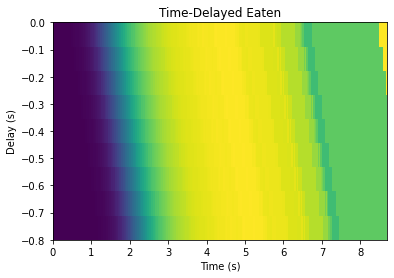

In [415]:
mask_time_ecog = mne.utils._time_mask(neural_tfr.times, 0, 8.7)

fig, ax = plt.subplots()
ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,
              np.nanmean(eat_delayed, axis= 0)[0], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Eaten')

/tmp/ipykernel_20319/4225806147.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,


Text(0.5, 1.0, 'Time-Delayed Time')

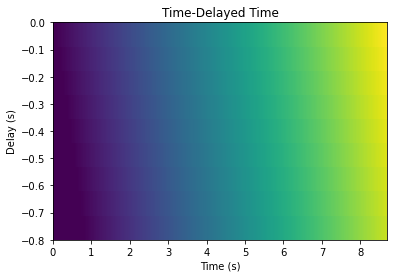

In [416]:
mask_time_ecog = mne.utils._time_mask(neural_tfr.times, 0, 8.7)

fig, ax = plt.subplots()
ax.pcolormesh(neural_tfr.times[mask_time_ecog], delays,
              np.nanmean(time_delayed, axis= 0)[0], cmap='viridis')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Time')

In [417]:
## Stack the data ##

# Stack neural trials #
theta_stacked = np.hstack(neural_data).T

# stack time and behavioral trials together
delayed_preds_tmp = delayed_preds.reshape([delayed_preds.shape[0], -1, delayed_preds.shape[-1]])
preds_stack = np.hstack(delayed_preds_tmp).T


In [418]:
theta_stacked.shape

(114101,)

In [419]:
preds_stack.shape

(114101, 10)

## Model Fitting

In [328]:
neural_data.shape

(131, 871)

In [329]:
n_cv_iterations = 5
cross_val_iterator = ms.KFold(n_splits=n_cv_iterations, shuffle=True)

/tmp/ipykernel_20319/1045768232.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(len(trials) + 1))


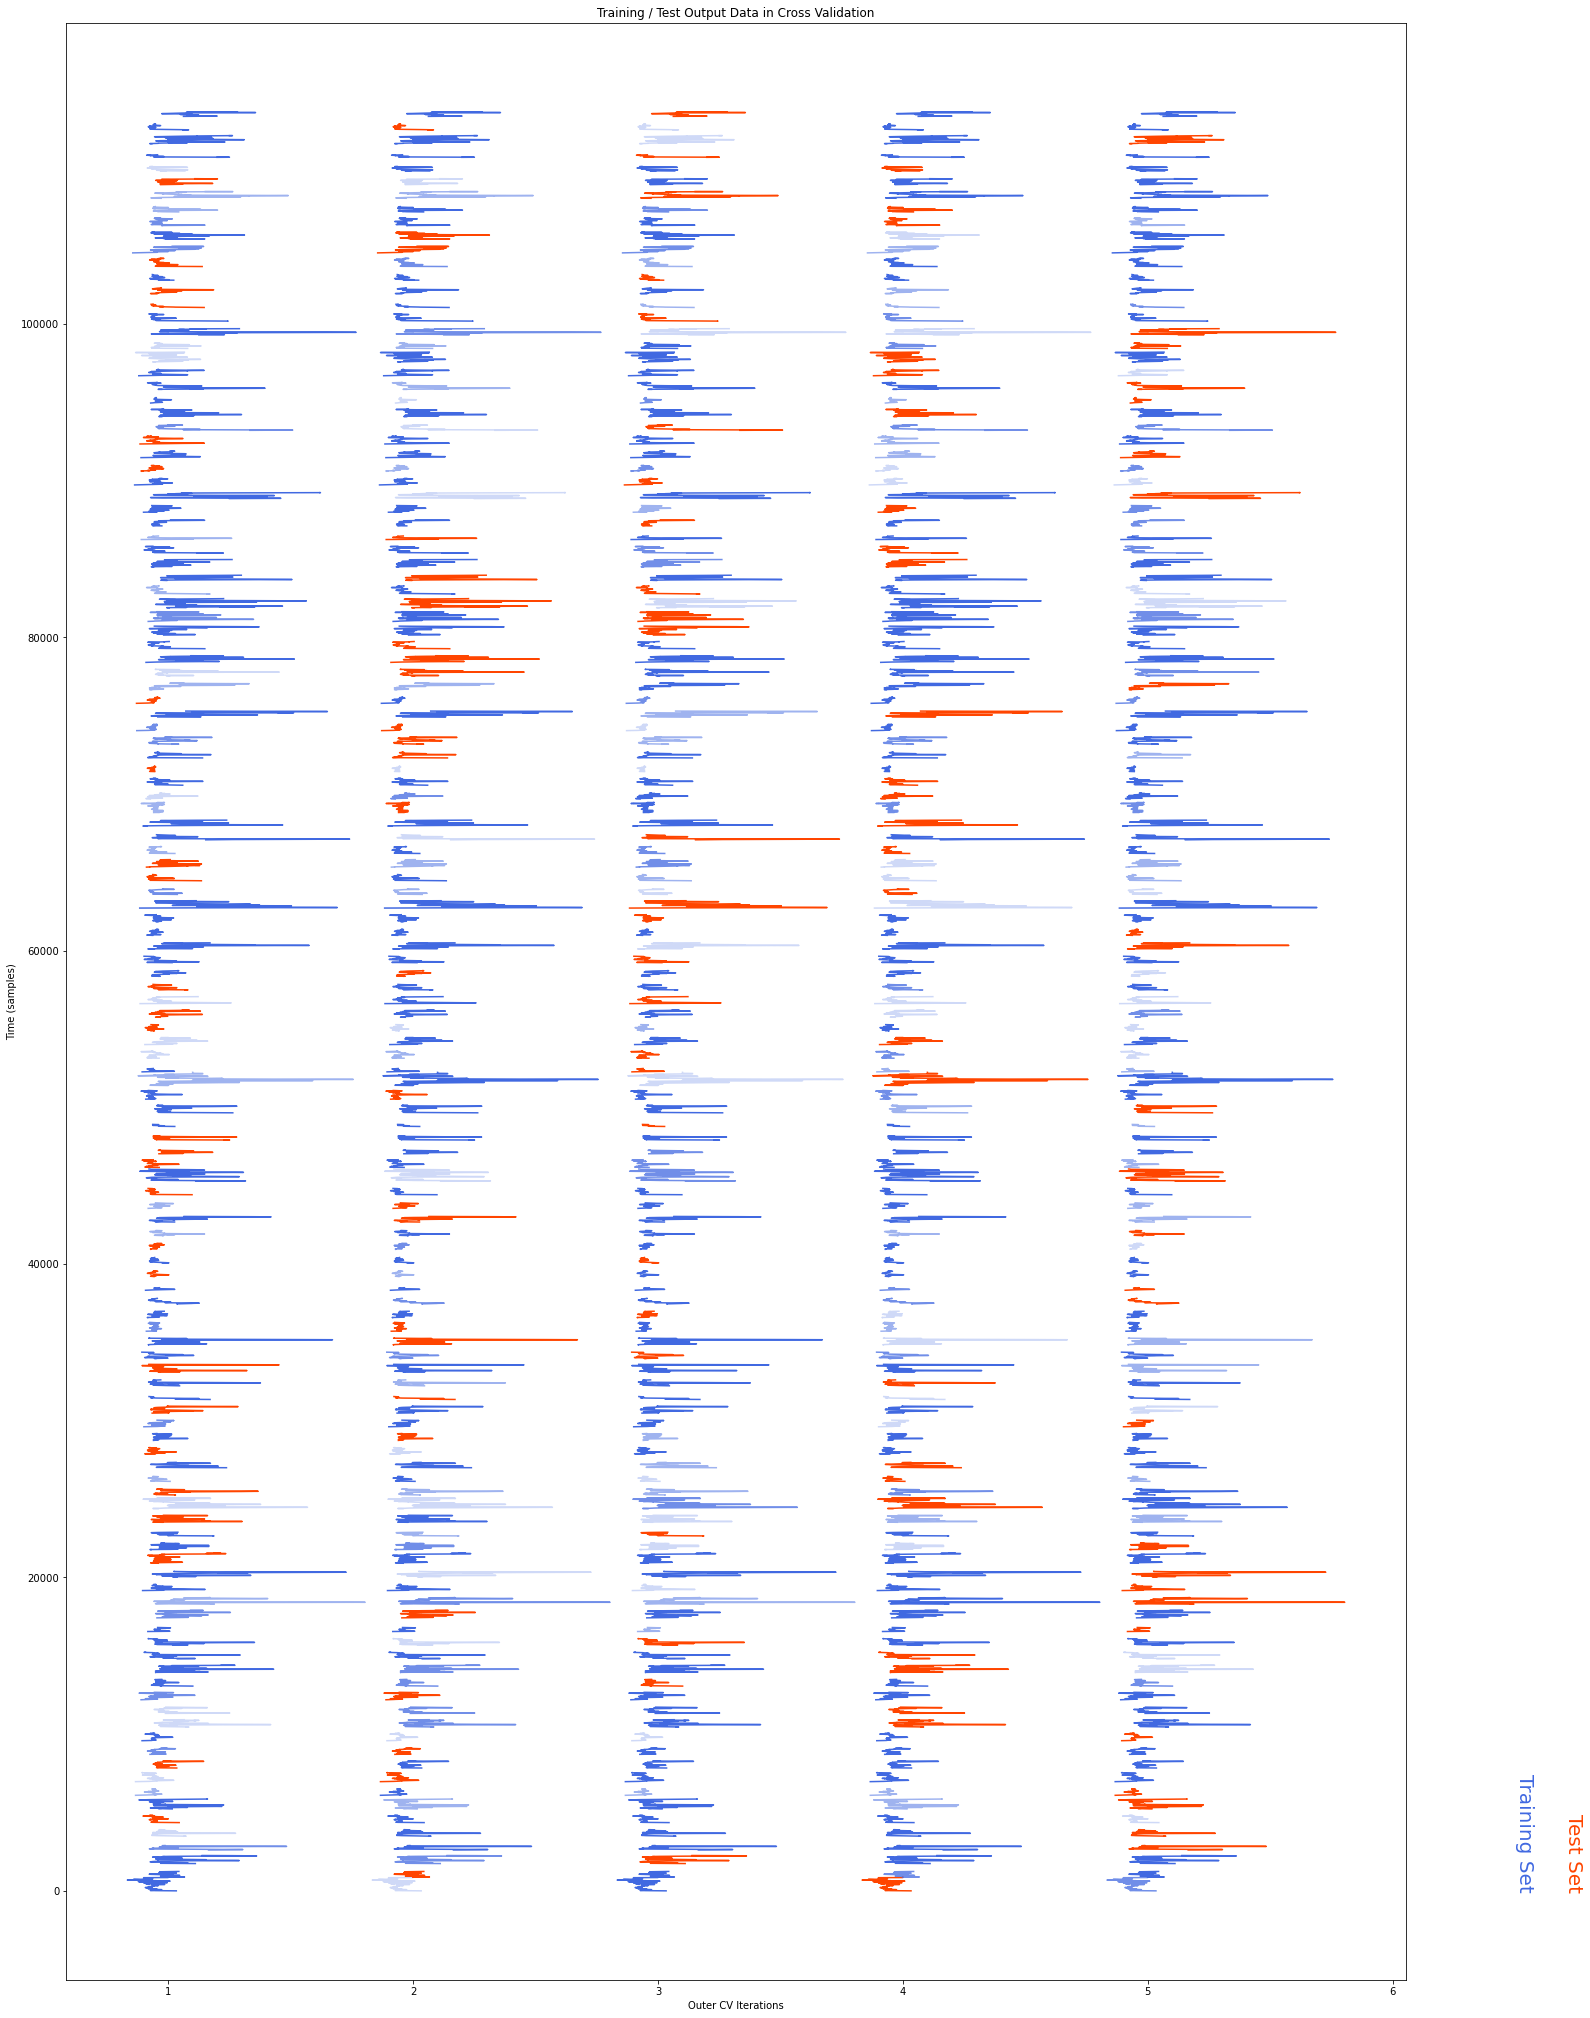

In [330]:
fig, ax = plt.subplots(figsize=(24, 36))
y = neural_data
y_plt = scale(neural_data)
trials = np.arange(neural_data.shape[0])

for ii, (tr, tt) in enumerate(cross_val_iterator.split(trials)):
    # Here we'll define the inner-loop cross validator, which would be used to tune hyperparamters
    # For each inner loop iteration, we'll shade the validation set slightly lighter
    cv_inner = ms.KFold(n_splits=8, shuffle=True)
    alphas = np.ones(len(trials))
    for (val_tr, val_tt), trans in zip(cv_inner.split(tr), [.25, .50, .75, 1.]):
        alphas[tr[val_tt]] = trans
        
    # Now create colors according to training / test sets
    colors = np.zeros(y.shape[0]).astype(bool)
    colors[tt] = True
    colors = np.where(colors, 'orangered', 'royalblue')

    # Make the plot
    for jj, (col, alpha, i_data) in enumerate(zip(colors, alphas, y_plt)):
        ixs = np.arange(len(i_data)) + jj * y_plt.shape[-1]
        i_plt = i_data + ii * 10
        ax.plot(i_plt, ixs, c=col, alpha=alpha)
        
ax.set_xlabel('Outer CV Iterations')
ax.set_xticklabels(range(len(trials) + 1))
ax.set_title('Training / Test Output Data in Cross Validation')
ax.set_ylabel('Time (samples)')
ax.text(55, 155, 'Training Set', color='royalblue',
        rotation=-90, fontsize=20, horizontalalignment='left')
ax.text(57, 155, 'Test Set', color='orangered',
        rotation=-90, fontsize=20, horizontalalignment='left')
ax.axis('tight')
# _ = plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

In [143]:
tt

array([  4,  24,  26,  27,  42,  44,  45,  47,  52,  64,  65,  71,  74,
        75,  80,  83,  88,  91,  95,  97, 107, 108, 110, 119, 126, 127,
       134])

In [136]:
y_tt.shape

(11052,)

In [137]:
predictions.shape ## need to undo this so we can look at trial specific predictions

(11052,)

In [138]:
neural_data.shape

(138, 871)

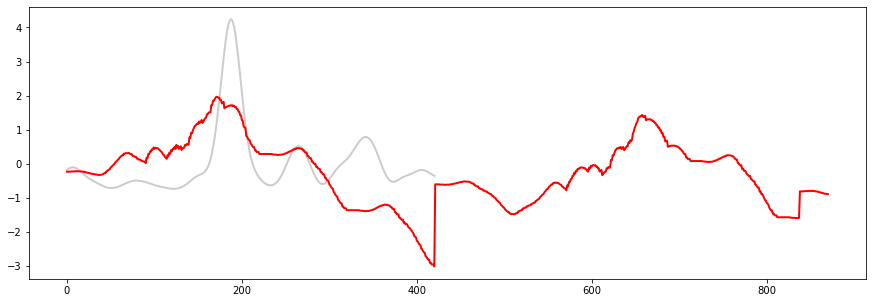

In [229]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(scale(y[tt[0], :]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions)[0:871], color='r', lw=2)
ax.axis('tight')
plt.show()

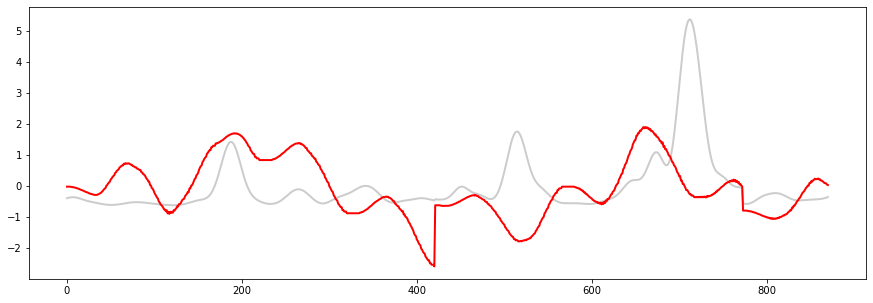

In [140]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(scale(y_tt[0:871]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions)[0:871], color='r', lw=2)
ax.axis('tight')
plt.show()

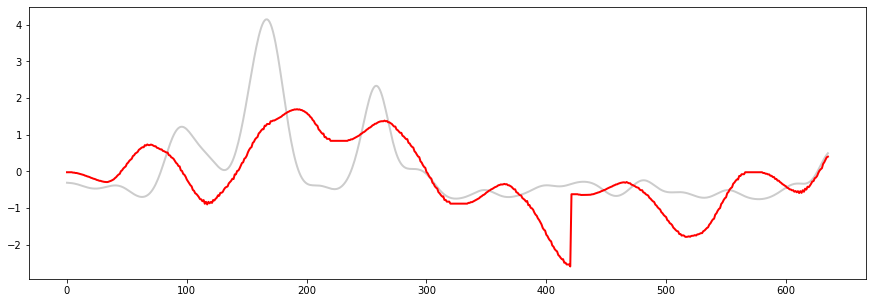

In [141]:
fig, ax = plt.subplots(figsize=(15, 5))

trial_7 = neural_data[7, :]
trial_7 = trial_7[~np.isnan(trial_7)]

ax.plot(scale(trial_7), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions)[0:len(trial_7)], color='r', lw=2)
ax.axis('tight')
plt.show()

In [181]:
tr.shape

(111,)

In [177]:
neural_data.shape

(138, 871)

In [178]:
predictions.shape

(11052,)

In [179]:
dist_delayed_tmp.shape

(138, 20, 871)

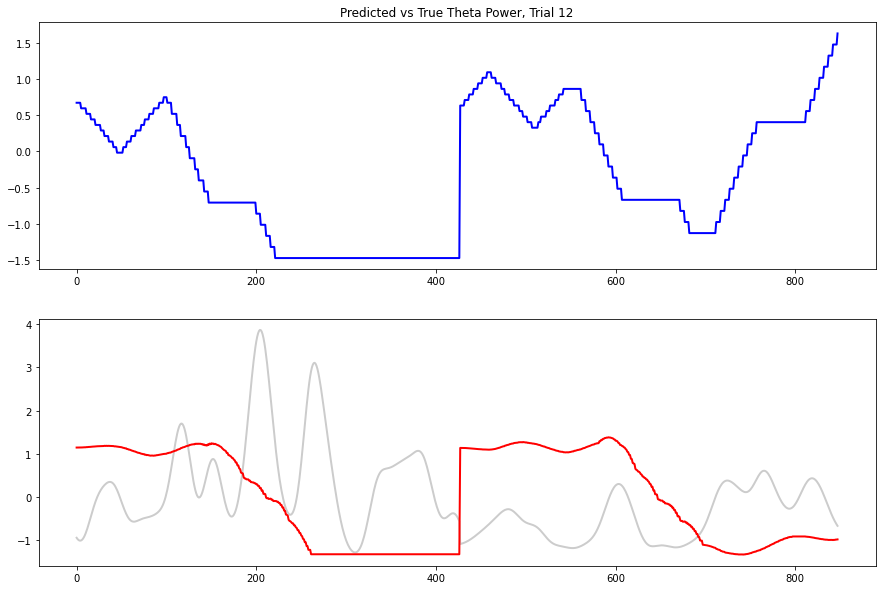

In [29]:
fig, (ax, ax1) = plt.subplots(2, figsize=(15, 10))

tidx1 = 3
tidx2 = 4

trial_7 = neural_data[tt[tidx1], :]
trial_7 = trial_7[~np.isnan(trial_7)]

trial_12 = neural_data[tt[tidx2], :]
trial_12 = trial_12[~np.isnan(trial_12)]

dist_values = np.hstack([delayed_preds_tmp[tt[tidx1], 19, :], delayed_preds_tmp[tt[tidx2], 19, :]])
dist_values = dist_values[~np.isnan(dist_values)]

previous_tt_trials = neural_data[tt[:tidx1], :]
begin_data = predictions[0:previous_tt_trials[~np.isnan(previous_tt_trials)].size]

ax.plot(dist_values, color='b', lw=2)
ax.axis('tight')
ax.set_title("Distance to Ghost, Trial 12")

ax1.plot(scale(np.hstack([trial_7, trial_12])), color='k', alpha=.2, lw=2)
ax1.plot(scale(predictions)[begin_data.size:(begin_data.size+len(trial_7)+len(trial_12))], color='r', lw=2)
ax1.axis('tight')
ax.set_title("Predicted vs True Theta Power, Trial 12")

plt.show()

## No Delays

-0.004083019137884669
-0.003256030930162357
-0.0006619554914297776
0.0001549727471087392
-0.000707082462969133


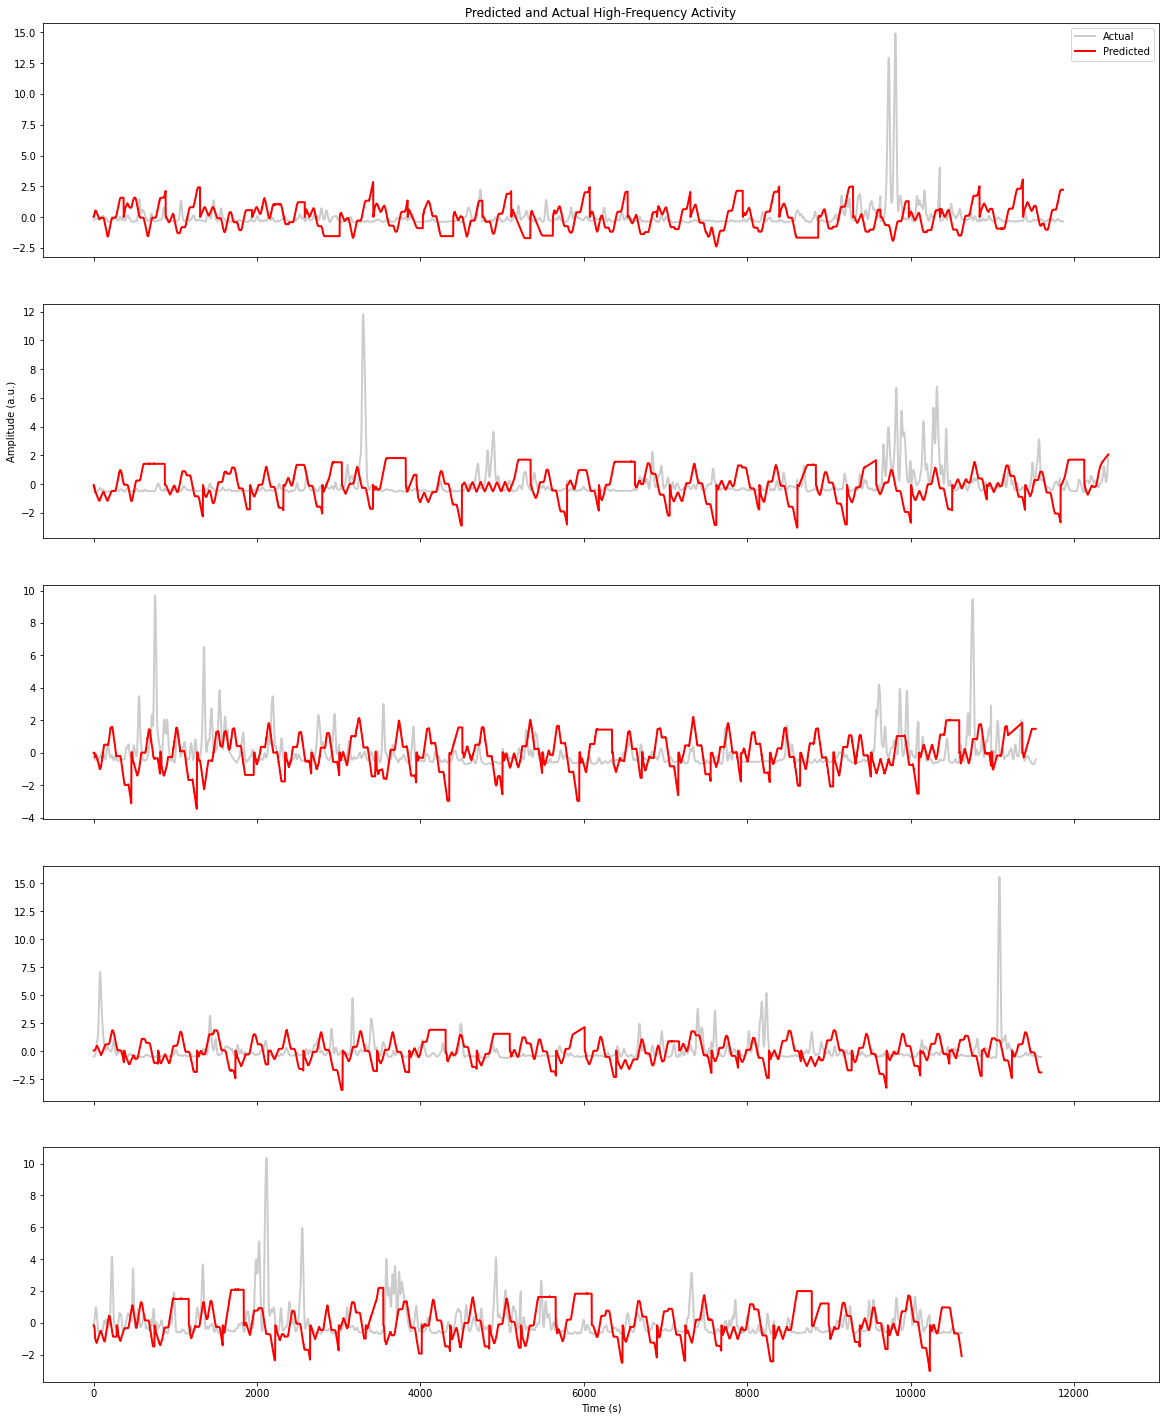

In [58]:
fig, axs = plt.subplots(5, 1,
                        figsize=(20, 5*5),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

X = dist_delayed_tmp[:, 10:19:, :]
y = neural_data
# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator.split(trials)):
    # Pull the training / testing data for the ecog data
    y_tr = np.hstack(y[tr]).T    
    y_tt = np.hstack(y[tt]).T
    
    # remove Nans 
    y_tr_ids = ~np.isnan(y_tr)
    y_tt_ids = ~np.isnan(y_tt)
    
    y_tr = y_tr[y_tr_ids]
    y_tt = y_tt[y_tt_ids]

    # Pull the training / testing data for the spectrogram
    X_tr = np.hstack(X[tr]).T
    X_tt = np.hstack(X[tt]).T
    
    X_tr = X_tr[y_tr_ids]
    X_tt = X_tt[y_tt_ids]
    
    # Scale all the features for simplicity
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)
    
    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(scale(y_tt), color='k', alpha=.2, lw=2)
    ax.plot(scale(predictions), color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))

_ = axs[0].legend(['Actual', 'Predicted'])
plt.show()

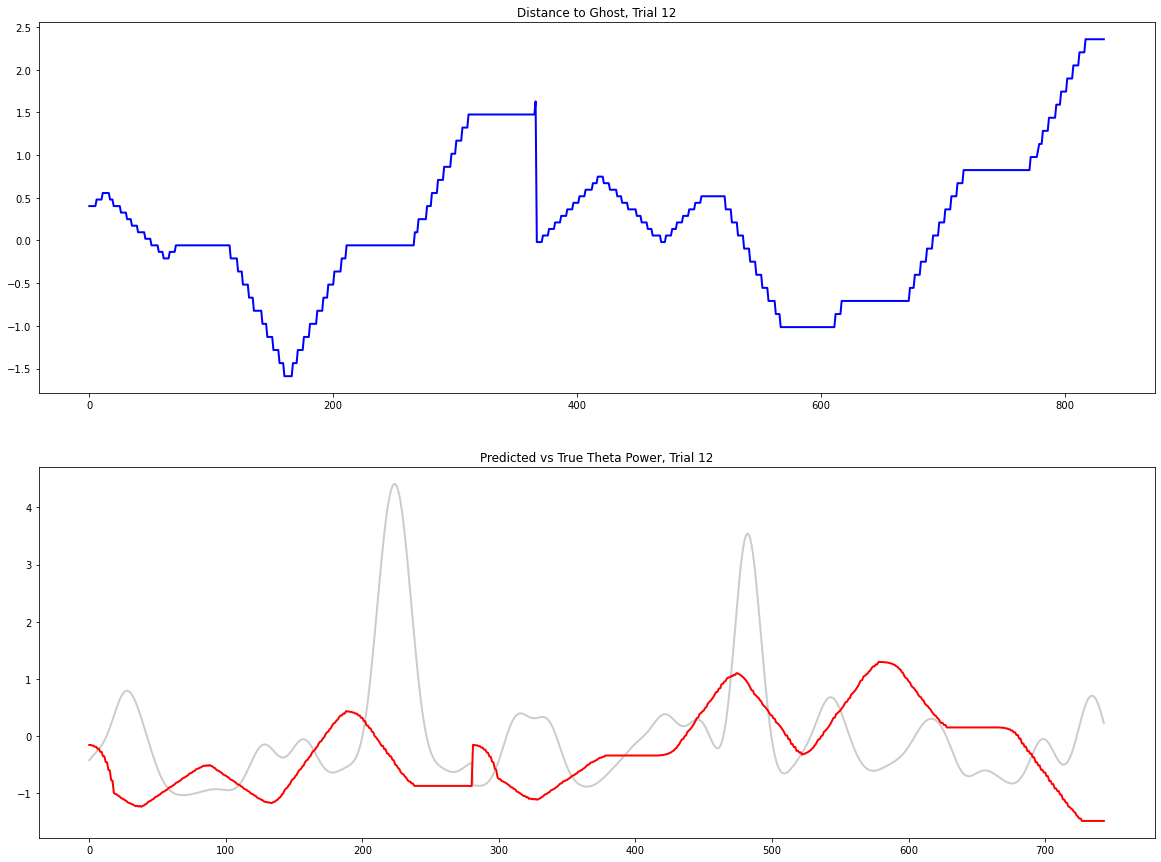

In [59]:
fig, (ax, ax1) = plt.subplots(2, figsize=(20, 15))

trial_7 = neural_data[tt[0:2], :]
trial_7 = trial_7[~np.isnan(trial_7)]

dist = np.hstack([dist_delayed_tmp[1, 19, :], dist_delayed_tmp[5, 19, :]])

ax.plot(dist[~np.isnan(dist)], color='b', lw=2)
ax.set_title("Distance to Ghost, Trial 12")

ax1.plot(scale(trial_7), color='k', alpha=.2, lw=2)
ax1.plot(scale(predictions)[0:len(trial_7)], color='r', lw=2)
ax1.set_title("Predicted vs True Theta Power, Trial 12")

plt.show()

In [324]:
np.hstack([dist_delayed_tmp[1, 19, :], dist_delayed_tmp[5, 19, :]])

array([80., 80., 80., ..., nan, nan, nan])

## Fit Hyperparameter

In [420]:
def cross_validate_alpha(X, y, trials, cv_outer, alphas, n_cv_inner=5):
    scores = np.zeros([cv_outer.get_n_splits(), n_cv_inner, len(alphas)])
    coefs = np.zeros([cv_outer.get_n_splits(), n_cv_inner,
                      len(alphas), X.shape[1]])
    pbar = mne.utils.ProgressBar(cv_outer.get_n_splits())
    for ii, (tr, tt) in enumerate(cv_outer.split(trials)):
        # Split trials into train/test sets
        outer_y_tr = y[tr]
        outer_y_tt = y[tt]
        
        outer_X_tr = X[tr]
        outer_X_tt = X[tt]

        # Now within the outer loop, do an inner loop for the ridge parameter
        cv_inner = ms.KFold(n_splits=n_cv_inner,
                            shuffle=True)
        for jj, (tr_val, tt_val) in enumerate(cv_inner.split(range(outer_y_tr.shape[0]))):
            # Create our training / testing data for the inner loop
   
            ## Prep y
            # stack and transpose
            inner_y_tr = np.hstack(outer_y_tr[tr_val]).T
            inner_y_tt = np.hstack(outer_y_tr[tt_val]).T

            # remove Nans 
            y_tr_ids = ~np.isnan(inner_y_tr)
            y_tt_ids = ~np.isnan(inner_y_tt)
            inner_y_tr = inner_y_tr[y_tr_ids]
            inner_y_tt = inner_y_tt[y_tt_ids]

            ## Prep X
            # stack and transpose
            inner_X_tr = np.hstack(outer_X_tr[tr_val]).T
            inner_X_tt = np.hstack(outer_X_tr[tt_val]).T

            inner_X_tr = inner_X_tr[y_tr_ids]
            inner_X_tt = inner_X_tt[y_tt_ids]            

            # inner_X_tr = scale(inner_X_tr)
            # inner_X_tt = scale(inner_X_tt)
            inner_y_tr = scale(inner_y_tr)
            inner_y_tt = scale(inner_y_tt)
        
            # For each alpha value, fit / score the model
            for kk, alpha in enumerate(alphas):
                model = Ridge(alpha=alpha)
                model.fit(inner_X_tr, inner_y_tr)
                score = r2_score(inner_y_tt, model.predict(inner_X_tt))
                scores[ii, jj, kk] = score
                coefs[ii, jj, kk] = model.coef_
        pbar.update(ii + 1)
    return scores, coefs

In [421]:
# Choose some log-spaced values for alpha
alphas = np.logspace(0,12, num = 20)
n_cv_outer = 5
n_cv_inner = 5

In [422]:
# This is our outer loop iterator
X = delayed_preds_tmp
y = neural_data

cv_outer = ms.KFold(n_splits=n_cv_outer, shuffle=True)
scores, coefs = cross_validate_alpha(X, y, trials, cv_outer, alphas, n_cv_inner)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

On each iteration, we fit and scored the model for a range of alpha parameters. We can take the average score of each alpha parameter, and see how they compare to one another.

In [423]:
coefs.shape

(5, 5, 20, 10)

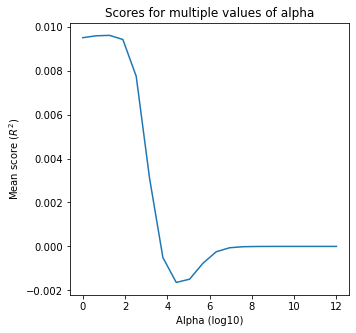

In [424]:
# Calculate the mean score across CV iterations (both inner and outer)
mean_scores = scores.mean(0).mean(0)

# Plot these values
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(np.log10(alphas), mean_scores)
ix_max = np.argmax(mean_scores)
ann_plt = (np.log10(alphas)[ix_max], mean_scores[ix_max])
ax.set_xlabel('Alpha (log10)')
ax.set_ylabel('Mean score ($R^2$)')
ax.set_title('Scores for multiple values of alpha')
plt.show()



In [425]:
np.log10(alphas[ix_max])

1.263157894736842

In [426]:
cross_val_iterator = ms.KFold(n_splits=5, shuffle=True)
model = Ridge(alpha=alphas[ix_max])

0.01535764452728905
0.013605381232529412
0.011327763203548225
0.01257589210413923
0.009453620516950312


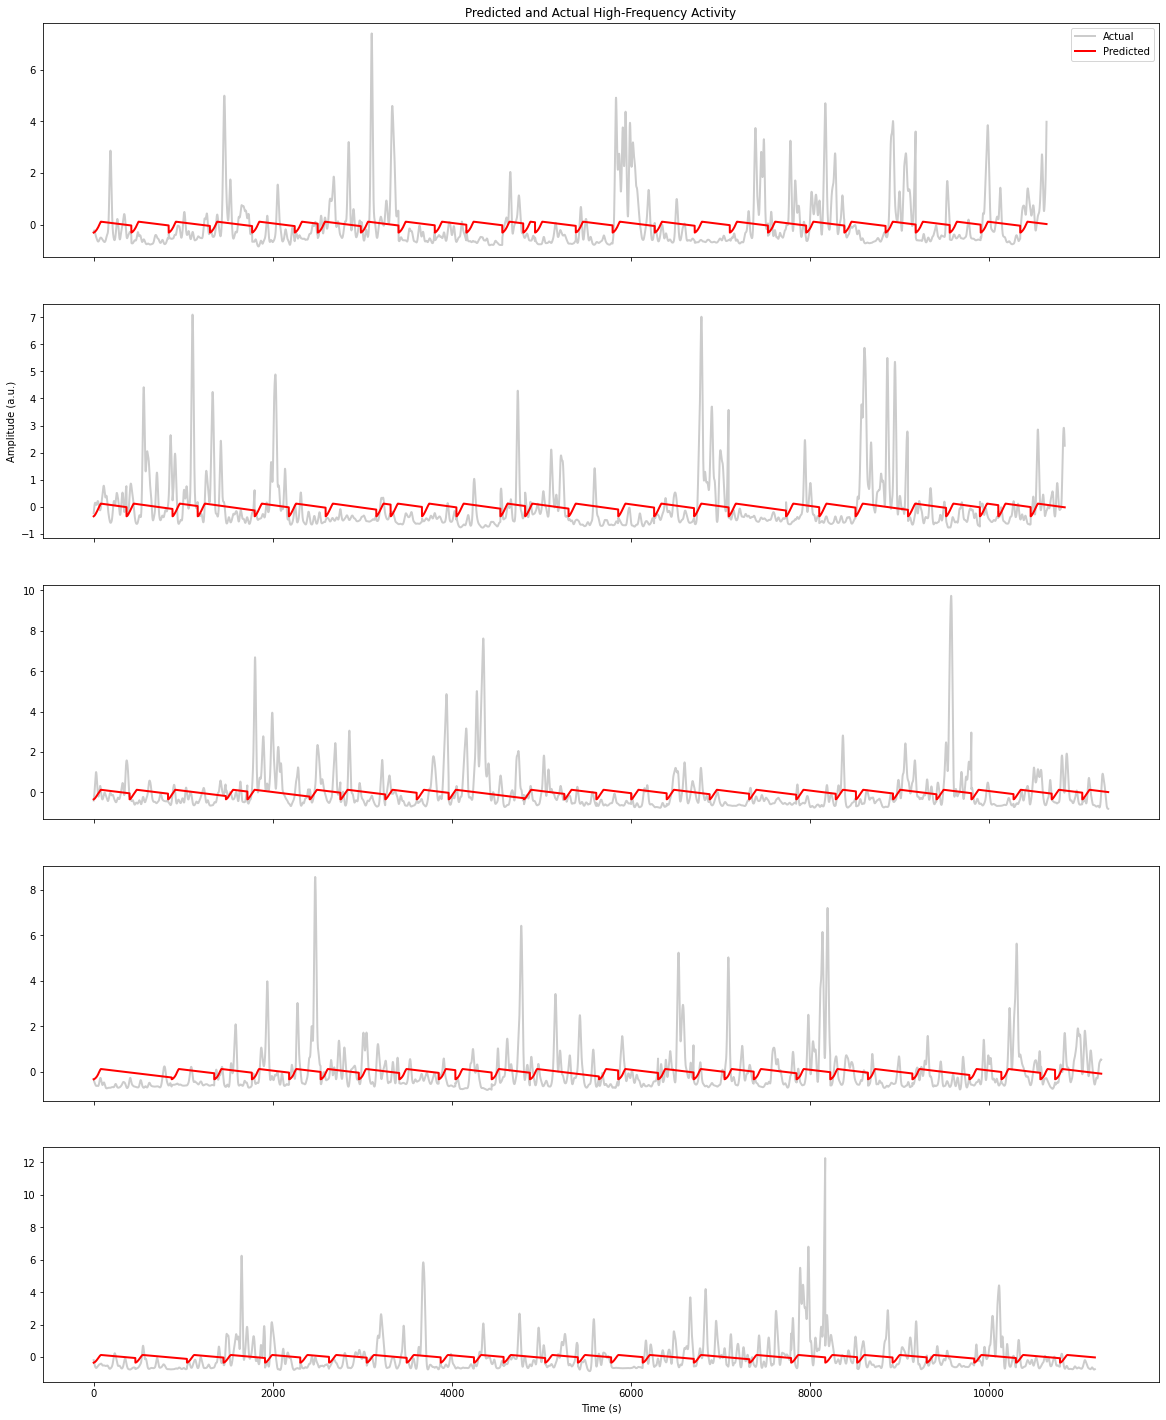

In [431]:
fig, axs = plt.subplots(5, 1,
                        figsize=(20, 5*5),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

X = delayed_preds_tmp
y = neural_data
# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator.split(trials)):
    # Pull the training / testing data for the ecog data
    y_tr = np.hstack(y[tr]).T    
    y_tt = np.hstack(y[tt]).T
    
    # remove Nans 
    y_tr_ids = ~np.isnan(y_tr)
    y_tt_ids = ~np.isnan(y_tt)
    
    y_tr = y_tr[y_tr_ids]
    y_tt = y_tt[y_tt_ids]

    # Pull the training / testing data for the spectrogram
    X_tr = np.hstack(X[tr]).T
    X_tt = np.hstack(X[tt]).T
    
    X_tr = X_tr[y_tr_ids]
    X_tt = X_tt[y_tt_ids]
    
    # Scale all the features for simplicity
    # X_tr = scale(X_tr)
    # X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)
    
    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(y_tt, color='k', alpha=.2, lw=2)
    ax.plot(predictions, color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))

_ = axs[0].legend(['Actual', 'Predicted'])
plt.show()

In [405]:
# from distance to ghost version
np.mean([0.009885963277489918, 0.011975191343301606, 0.0084090599505805, -0.0011187295032011324, -0.0014877104236881156])

0.005532754928896555

In [436]:
np.mean([0.01535764452728905, 0.013605381232529412, 0.011327763203548225, 0.01257589210413923, 0.009453620516950312])

0.012464060316891245

In [432]:
tt

array([  5,   8,  10,  16,  22,  30,  34,  35,  37,  45,  48,  64,  67,
        80,  82,  92,  93,  97, 102, 107, 111, 117, 119, 121, 122, 129])

In [433]:
y[tt[0], ~np.isnan(y[tt[0], :])].shape

(466,)

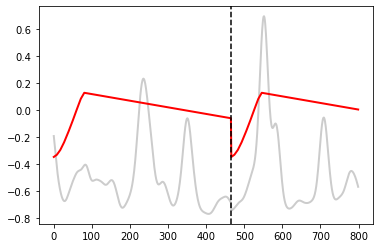

In [434]:

plt.plot(y_tt[0:800], color='k', alpha=.2, lw=2)
plt.plot(predictions[0:800], color='r', lw=2)
plt.axvline(x=466, color='black', linestyle='--')
plt.show()

## Validation I have the right trial order

In [231]:
neural_data.shape

(131, 871)

In [214]:
y.shape

(131, 871)

In [219]:
y[130, ~np.isnan(y[130, :])]

(294,)

In [237]:
y_tr.shape

(43709,)

In [139]:
X_tr.shape

(45371, 60)

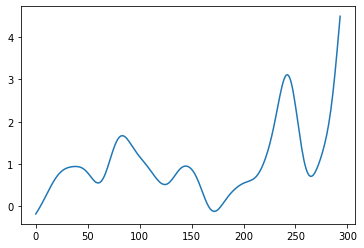

In [236]:
plt.plot(y_tr[(43709-294):(43709)])

Alright. We got from a full trial list (240) to 211 trials in the sample_elec_data.

Then we go from 211 to 138 by excluding no ghost and death trials in trial_data.

Then we go from 138 to 131 within trial_data by excluding outliers.

We keep the same last index because trial 130 is included in tr.

Finally based on trial_data which has shape 211, this is actually trial 236

So trial 211 -> becomes 138 (because it is not a noghost or death trial) We access it w/ 137 instead of 210

After dropping big power trials, 138 -> 131, which we access in 130 because trial 137 is in the good trial list

130 is also in tr so it should be in y_tr

And we got there! The problem was thinking there nans in y_tr

SO the y_tr list look correct. I can reindex trials as expected. so lets check out the behavioral data


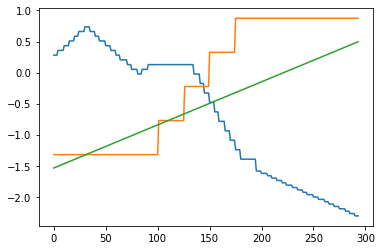

In [241]:
plt.plot(X_tr[(43709-294):(43709), 19])
plt.plot(X_tr[(43709-294):(43709), 39])
plt.plot(X_tr[(43709-294):(43709), 59])
plt.show()

In [243]:
trial_data[trial_data['Trial'] == 236]

,Unnamed: 0,Subject,Trial_on_off,sample,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,...,Attack,Chase,Eaten,Score,Lives,TrialType,Trial,Time,distance_to_ghost,time_pred
88983,102498,BJH025,1,2905900,46,123,4,0,0,0,...,0,0,0,800,1,2,236,0.00,0.288156,-1.520738
88984,102499,BJH025,1,2905920,46,123,4,0,0,0,...,0,0,0,800,1,2,236,0.01,0.288156,-1.513982
88985,102500,BJH025,1,2905940,46,123,4,0,0,0,...,0,0,0,800,1,2,236,0.02,0.288156,-1.507226
88986,102501,BJH025,1,2905960,46,123,4,0,0,0,...,0,0,0,800,1,2,236,0.03,0.288156,-1.500470
88987,102502,BJH025,1,2905980,44,123,4,0,0,0,...,0,0,0,800,1,2,236,0.04,0.364787,-1.493714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89273,102788,BJH025,1,2911700,110,119,11,1,1,1,...,1,0,4,800,1,2,236,2.90,-2.317327,0.438458
89274,102789,BJH025,1,2911720,110,119,11,1,1,1,...,1,0,4,800,1,2,236,2.91,-2.317327,0.445214
89275,102790,BJH025,1,2911740,110,119,11,1,1,1,...,1,0,4,800,1,2,236,2.92,-2.317327,0.451970
89276,102791,BJH025,1,2911760,110,119,11,1,1,1,...,1,0,4,800,1,2,236,2.93,-2.317327,0.458726
